# Objective

In this notebook, the exploratory data analysis is performed on the image datasets we have for brain tumour type classification:
- no_tumor (normal)
- pituitary_tumor
- meningioma_tumor
- glioma_tumor
The images are stored in one folder per type of tumor in a train folder and in a test folder. We will inspect here the characteristics of the training dataset.

Then, three different CNN models with transfer learning will be used to extract image features and see how these models perform in classifying the types of brain tumours:

- ResNet Mixed Convolution model
- 

# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
%matplotlib inline
from sklearn.decomposition import PCA
from math import ceil

# Exploratory data analysis

I am going to perform the same steps as described in this blog post for exploratory data analysis on images : https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2 

## Raw Comparison

First, we can start by simply looking at a few randomly sampled images.

In [2]:
train_dir = 'data/Training' # image folder

In [3]:
# get the list of jpegs from sub image class folders
glioma_imgs = [fn for fn in os.listdir(f'{train_dir}/glioma_tumor') if fn.endswith('.jpg')]
meningioma_imgs = [fn for fn in os.listdir(f'{train_dir}/meningioma_tumor') if fn.endswith('.jpg')]
normal_imgs = [fn for fn in os.listdir(f'{train_dir}/no_tumor') if fn.endswith('.jpg')]
pituitary_imgs = [fn for fn in os.listdir(f'{train_dir}/pituitary_tumor') if fn.endswith('.jpg')]

In [4]:
# randomly select 3 of each
select_glioma = np.random.choice(glioma_imgs, 3, replace = False)
select_meningioma = np.random.choice(meningioma_imgs, 3, replace = False)
select_normal = np.random.choice(normal_imgs, 3, replace = False)
select_pituitary = np.random.choice(pituitary_imgs, 3, replace = False)

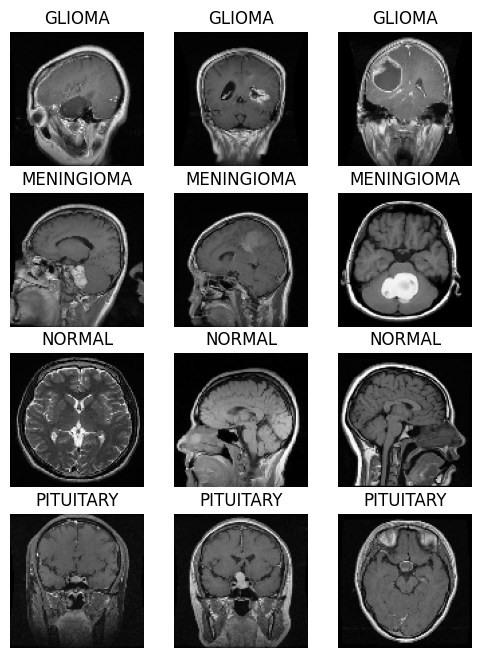

In [5]:
# plotting 4 x 3 image matrix
fig = plt.figure(figsize=(6,8))
for i in range(12):
    if i < 3:
        fp = f'{train_dir}/glioma_tumor/{select_glioma[i]}'
        label = 'GLIOMA'
    elif 3 <= i < 6:
        fp = f'{train_dir}/meningioma_tumor/{select_meningioma[i-3]}'
        label = 'MENINGIOMA'
    elif 6 <= i < 9:
        fp = f'{train_dir}/no_tumor/{select_normal[i-6]}'
        label = 'NORMAL'
    else:
        fp = f'{train_dir}/pituitary_tumor/{select_pituitary[i-9]}'
        label = 'PITUITARY'
    ax = fig.add_subplot(4, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

In [6]:
# also check the number of files here
len(glioma_imgs), len(meningioma_imgs), len(normal_imgs), len(pituitary_imgs)

(826, 822, 395, 827)

We note that we have 395 normal images while about 820 tumor images in our training dataset. 

## Images as Matrix

For the next few steps, we will work directly with the pixel values of each image so we can do operations on them. We can accomplish this by converting our images into a Numpy array.

In [7]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [8]:
# run it on our folders
normal_images = img2np(f'{train_dir}/no_tumor/', normal_imgs)
glioma_images = img2np(f'{train_dir}/glioma_tumor/', glioma_imgs)
meningioma_images = img2np(f'{train_dir}/meningioma_tumor/', meningioma_imgs)
pituitary_images = img2np(f'{train_dir}/pituitary_tumor/', pituitary_imgs)

In [9]:
# We should have 395 1D array for normal images
normal_images.shape

(395, 4096)

In [10]:
# We should have 826 1D array for normal images
glioma_images.shape

(826, 4096)

## Average Image

Now let’s see what the average image looks like for each class. To compute the average image, we can take the average value of each pixel across all observations.

In [11]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

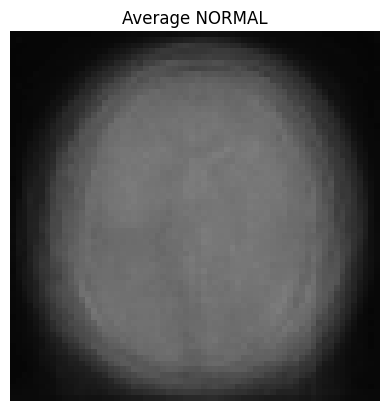

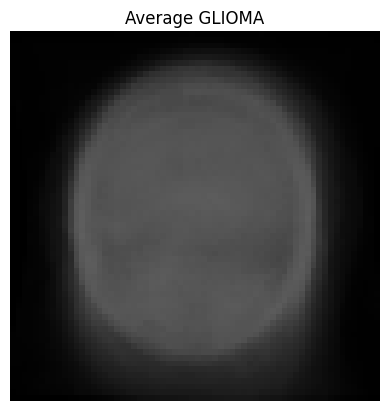

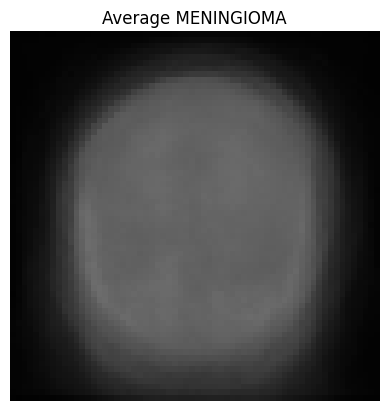

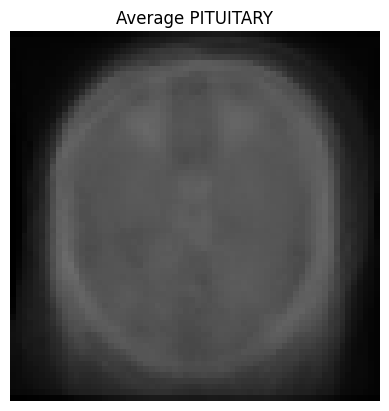

In [12]:
norm_mean = find_mean_img(normal_images, 'NORMAL')
glioma_mean = find_mean_img(glioma_images, 'GLIOMA')
meningioma_mean = find_mean_img(meningioma_images, 'MENINGIOMA')
pituitary_mean = find_mean_img(pituitary_images, 'PITUITARY')

In our case, average of each class does not bring more informations. We can check the contrast between average images.

## Contrast Between Average Images

I will check the contrast between the different combinations of classes.

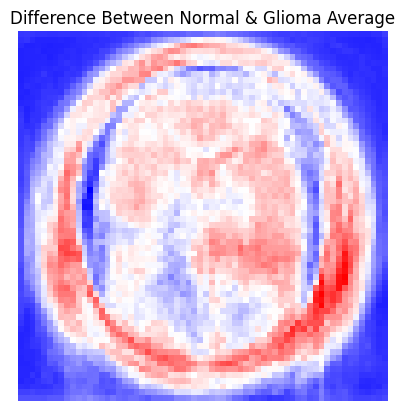

In [13]:
contrast_mean_norm_glioma = norm_mean - glioma_mean
plt.imshow(contrast_mean_norm_glioma, cmap='bwr')
plt.title(f'Difference Between Normal & Glioma Average')
plt.axis('off')
plt.show()

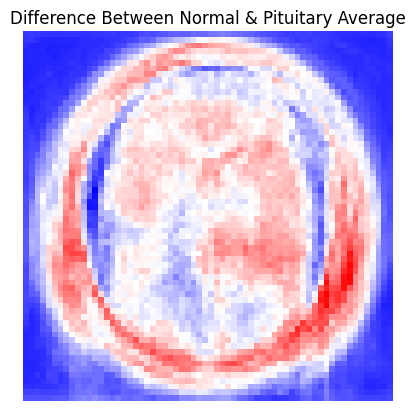

In [14]:
contrast_mean_norm_pituitary = norm_mean - pituitary_mean
plt.imshow(contrast_mean_norm_glioma, cmap='bwr')
plt.title(f'Difference Between Normal & Pituitary Average')
plt.axis('off')
plt.show()

Between the normal and pituitary or glioma, the contrasted zones look the same.

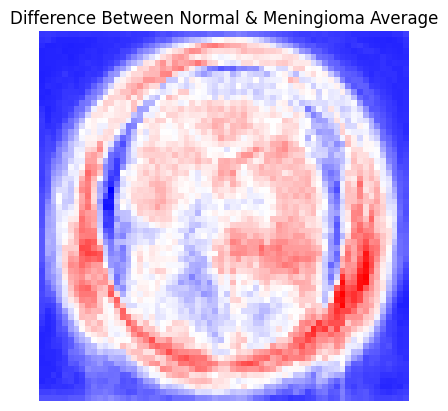

In [15]:
contrast_mean_norm_meningioma = norm_mean - meningioma_mean
plt.imshow(contrast_mean_norm_glioma, cmap='bwr')
plt.title(f'Difference Between Normal & Meningioma Average')
plt.axis('off')
plt.show()

Since the averages are very similar, the contrast between them is also very similar.

## Eigenimages

Lastly, we can use a dimension reduction technique such as the principal component analysis (PCA) to visualize the components that describe each class the best. The eigenimages, which is essentially the eigenvectors (components) of PCA of our image matrix, can be reshaped into a matrix and be plotted. It’s also called eigenfaces as this approach was first used for facial recognition research. Here we will visualize the principal components that describe 70% of variability for each class.

In [16]:
def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()

Normal images
Number of PC:  43


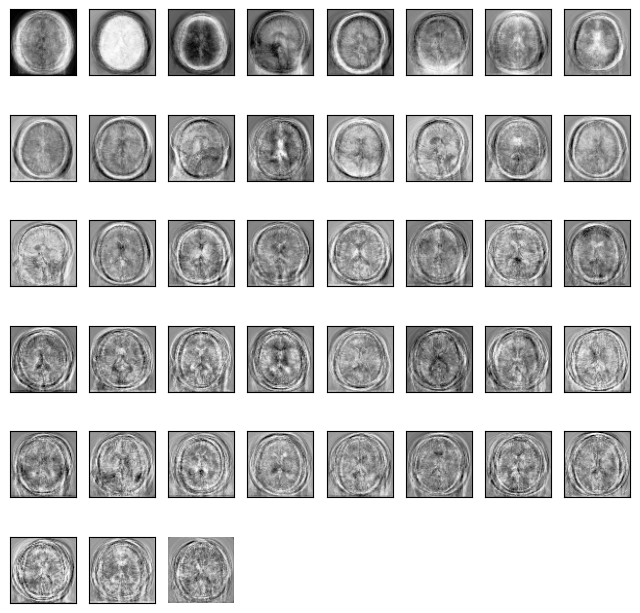

In [18]:
print("Normal images")
plot_pca(eigenimages(normal_images, 'NORMAL'))

Glioma images
Number of PC:  82


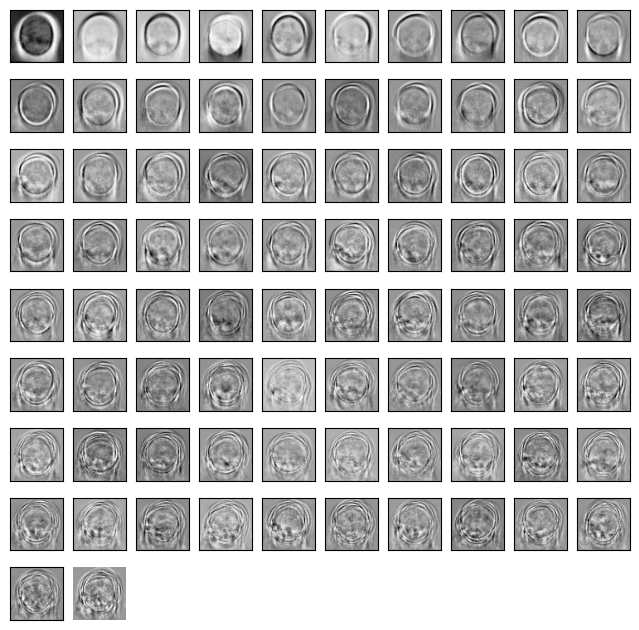

In [19]:
print("Glioma images")
plot_pca(eigenimages(glioma_images, 'GLIOMA'))

Meningioma images
Number of PC:  63


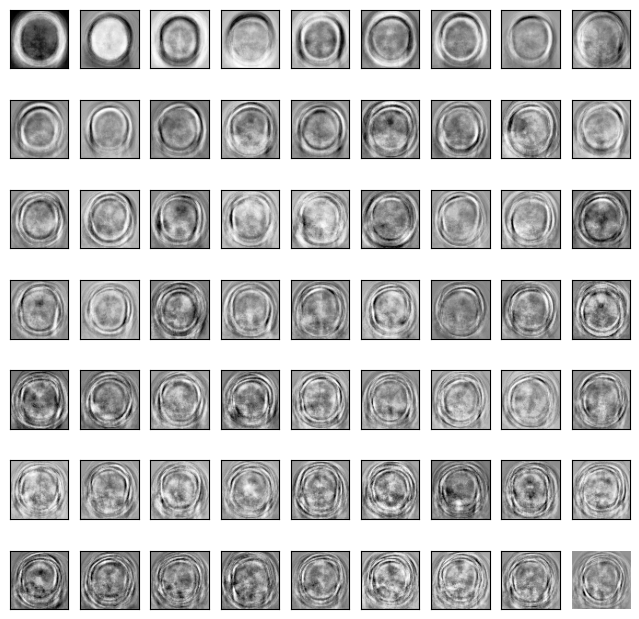

In [20]:
print("Meningioma images")
plot_pca(eigenimages(meningioma_images, 'MENINGIOMA'))

Pituitary images
Number of PC:  73


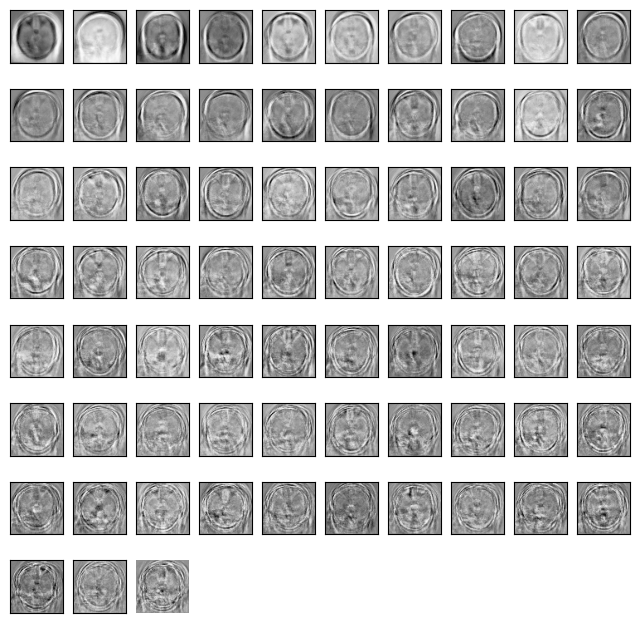

In [21]:
print("Pituitary images")
plot_pca(eigenimages(pituitary_images, 'PITUITARY'))